In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import libraries for Data Imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Import libraries for training Machine Learning Models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Import libraries to normalise the dataset
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

#Import libraries for evaluating the ML model performance
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, cross_val_predict

In [2]:
# Load the dataset
datacovid = pd.read_excel('dataset.xlsx')
datacovid.shape

(5644, 111)

In [3]:
# Check for missing values
datacovid.isnull().sum()

Patient ID                                                  0
Patient age quantile                                        0
SARS-Cov-2 exam result                                      0
Patient addmited to regular ward (1=yes, 0=no)              0
Patient addmited to semi-intensive unit (1=yes, 0=no)       0
                                                         ... 
HCO3 (arterial blood gas analysis)                       5617
pO2 (arterial blood gas analysis)                        5617
Arteiral Fio2                                            5624
Phosphor                                                 5624
ctO2 (arterial blood gas analysis)                       5617
Length: 111, dtype: int64

In [4]:
# Select all columns with object or categorical datatype except 'Patient ID' to understand the dataset
cat_cols = [col for col in datacovid.select_dtypes(include=['object']).columns if col != 'Patient ID']

# Print the unique values in each categorical column
for col in cat_cols:
    print(col, datacovid[col].unique())

SARS-Cov-2 exam result ['negative' 'positive']
Respiratory Syncytial Virus [nan 'not_detected' 'detected']
Influenza A [nan 'not_detected' 'detected']
Influenza B [nan 'not_detected' 'detected']
Parainfluenza 1 [nan 'not_detected' 'detected']
CoronavirusNL63 [nan 'not_detected' 'detected']
Rhinovirus/Enterovirus [nan 'detected' 'not_detected']
Coronavirus HKU1 [nan 'not_detected' 'detected']
Parainfluenza 3 [nan 'not_detected' 'detected']
Chlamydophila pneumoniae [nan 'not_detected' 'detected']
Adenovirus [nan 'not_detected' 'detected']
Parainfluenza 4 [nan 'not_detected' 'detected']
Coronavirus229E [nan 'not_detected' 'detected']
CoronavirusOC43 [nan 'not_detected' 'detected']
Inf A H1N1 2009 [nan 'not_detected' 'detected']
Bordetella pertussis [nan 'not_detected' 'detected']
Metapneumovirus [nan 'not_detected' 'detected']
Parainfluenza 2 [nan 'not_detected']
Influenza B, rapid test [nan 'negative' 'positive']
Influenza A, rapid test [nan 'negative' 'positive']
Strepto A [nan 'positiv

In [5]:
# Count number of positive and negative SARS-Cov-2 cases
positive_results = (datacovid['SARS-Cov-2 exam result'] == 'positive').sum()
negative_results = (datacovid['SARS-Cov-2 exam result'] == 'negative').sum()

# Print counts
print("Total number of positive results for SARS-Cov-2 cases for original dataset:", positive_results)
print("Total number of negative results for SARS-Cov-2 cases for original dataset:", negative_results)

Total number of positive results for SARS-Cov-2 cases for original dataset: 558
Total number of negative results for SARS-Cov-2 cases for original dataset: 5086


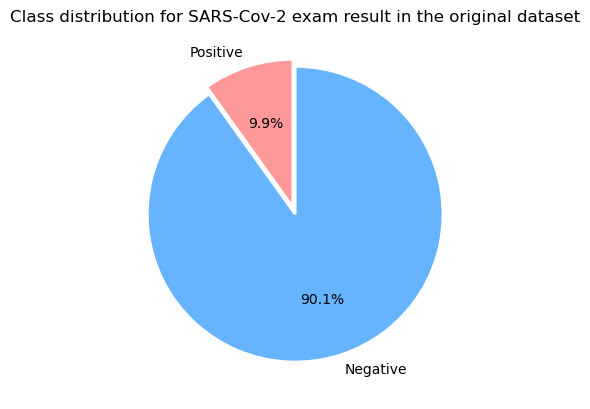

In [6]:
# Calculate percentages
total_results = positive_results + negative_results
positive_percent = (positive_results / total_results) * 100
negative_percent = (negative_results / total_results) * 100

# Create pie chart
labels = ['Positive', 'Negative']
sizes = [positive_percent, negative_percent]
colors = ['#ff9999','#66b3ff']
explode = (0.05, 0)

fig, ax = plt.subplots()

# Create white circle to highlight break
circle = plt.Circle(xy=(0,0), radius=0.6, facecolor='white')
ax.add_artist(circle)

# Create pie chart
ax.pie(sizes, colors=colors, labels=labels, autopct='%1.1f%%', startangle=90, explode=explode, wedgeprops={'linewidth': 2, 'edgecolor': 'white'})

# Add title
plt.title('Class distribution for SARS-Cov-2 exam result in the original dataset')

# Show plot
plt.show()

In [7]:
# Compute the percentage of null values in each column
null_percentage = (datacovid.isnull().sum() / datacovid.shape[0]) * 100

# Sort the null percentages in descending order
null_percentage_sorted = null_percentage.sort_values(ascending=False)

# Compute the percentage of null values in the dataframe
overall_null_percentage = (datacovid.isnull().sum().sum() / (datacovid.shape[0] * datacovid.shape[1])) * 100

# Round the null percentage to 4 decimal places
overall_null_percentage = round(overall_null_percentage, 4)

print("Percentage of null values in the COVID-19 dataset:", overall_null_percentage, "%")

Percentage of null values in the COVID-19 dataset: 88.06 %


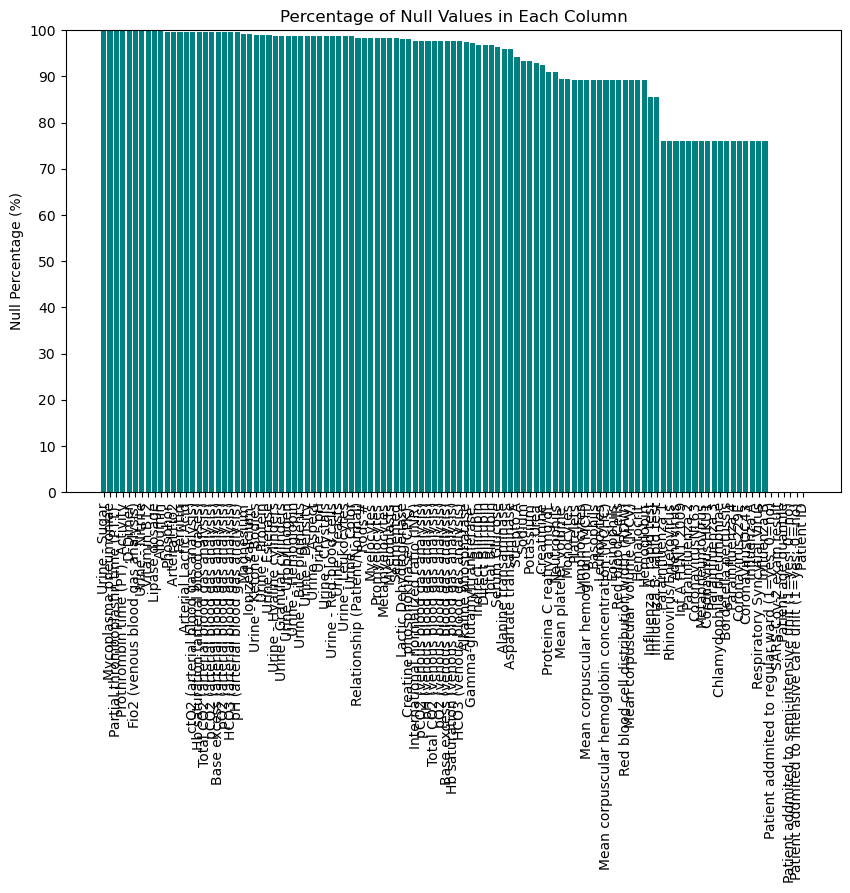

In [8]:
# Create a bar chart of the null percentages
plt.figure(figsize=(10, 6))
plt.bar(null_percentage_sorted.index, null_percentage_sorted, color='teal')
plt.xticks(rotation=90)
plt.ylabel('Null Percentage (%)')
plt.title('Percentage of Null Values in Each Column')
plt.ylim(0, 100)
plt.yticks(np.arange(0, 101, 10))
plt.show()

In [9]:
# Display columns with more than 90% missing data
null_percentage_sorted_90 = null_percentage_sorted[null_percentage_sorted > 90]
print("Columns with more than 90% missing data:\n", null_percentage_sorted_90)

Columns with more than 90% missing data:
 Urine - Sugar                         100.000000
Mycoplasma pneumoniae                 100.000000
Partial thromboplastin time (PTT)     100.000000
Prothrombin time (PT), Activity       100.000000
D-Dimer                               100.000000
                                         ...    
Potassium                              93.426648
Urea                                   92.965982
Creatinine                             92.487597
Proteina C reativa mg/dL               91.034727
Neutrophils                            90.910702
Length: 72, dtype: float64


In [10]:
# Drop columns with more than 90% null values
datacovid2 = datacovid.drop(null_percentage[null_percentage > 90].index, axis=1)
datacovid2.head()

,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,...,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,"Influenza B, rapid test","Influenza A, rapid test"
0,44477f75e8169d2,13,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126e9dd13932f68,17,negative,0,0,0,0.236515,-0.02234,-0.517413,0.010677,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,negative,negative
2,a46b4402a0e5696,8,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f7d619a94f97c45,5,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,d9e41465789c2b5,15,negative,0,0,0,NaN,NaN,NaN,NaN,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,NaN,NaN


In [11]:
datacovid2.shape

(5644, 39)

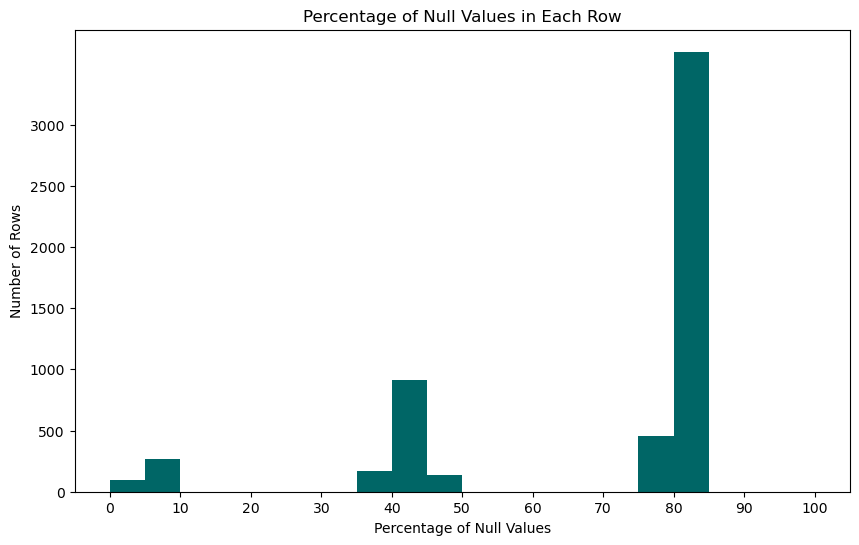

In [12]:
# Compute the percentage of null values in each row
row_null_percentage = (datacovid2.isnull().sum(axis=1) / datacovid2.shape[1]) * 100

# Plot a histogram of the null percentages
plt.figure(figsize=(10, 6))
plt.hist(row_null_percentage, bins=20, range=(0, 100), color='#006666')
plt.xlabel('Percentage of Null Values')
plt.ylabel('Number of Rows')
plt.title('Percentage of Null Values in Each Row')
plt.xticks(np.arange(0, 101, 10))
plt.yticks(np.arange(0, 3500, 500))
plt.show()

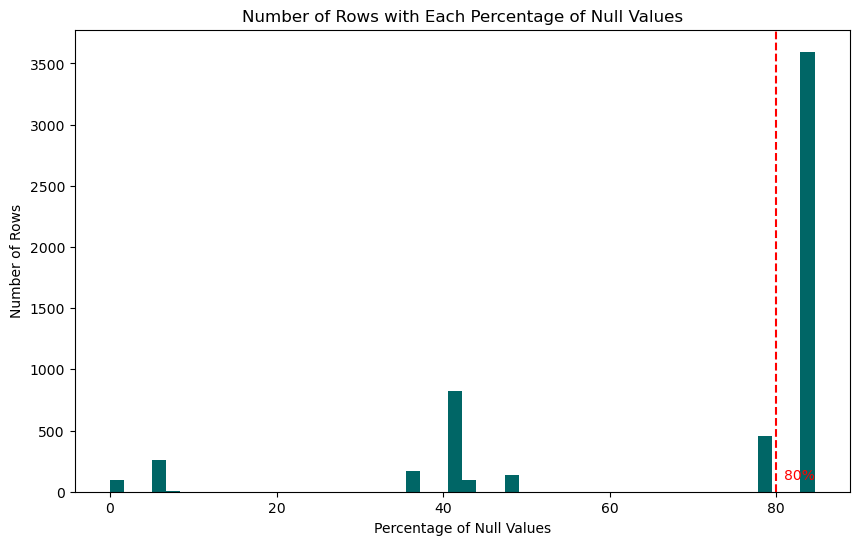

Number of rows remaining after dropping rows with more than 80% null values: 2048


In [13]:
# Compute the number of rows with more than 80% null values
rows_to_drop = sum(row_null_percentage > 80)

# Compute the total number of rows remaining
rows_remaining = datacovid2.shape[0] - rows_to_drop

# Create a bar chart of the null percentages in rows
plt.figure(figsize=(10, 6))
plt.hist(row_null_percentage, bins=50, color='#006666')
plt.xlabel('Percentage of Null Values')
plt.ylabel('Number of Rows')
plt.title('Number of Rows with Each Percentage of Null Values')
plt.axvline(x=80, color='r', linestyle='--')
plt.text(81, 100, '80%', color='r')
plt.show()

print("Number of rows remaining after dropping rows with more than 80% null values:", rows_remaining)

In [14]:
# Drop rows with more than 80% null values
datacovid3 = datacovid2.dropna(thresh=datacovid2.shape[1]*0.2)
datacovid3.head()

,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,...,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,"Influenza B, rapid test","Influenza A, rapid test"
1,126e9dd13932f68,17,negative,0,0,0,0.236515,-0.022340,-0.517413,0.010677,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,negative,negative
4,d9e41465789c2b5,15,negative,0,0,0,NaN,NaN,NaN,NaN,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,NaN,NaN
8,8bb9d64f0215244,1,negative,0,1,0,-1.571682,-0.774212,1.429667,-1.672222,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,NaN,NaN
9,5f1ed301375586c,17,negative,0,0,0,NaN,NaN,NaN,NaN,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,NaN,NaN
13,0fbafd910aa8078,13,negative,0,0,0,NaN,NaN,NaN,NaN,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,NaN,NaN


In [15]:
datacovid3.shape

(2048, 39)

In [16]:
# Get rows with more than 60% non-null values
valid_rows = datacovid3[datacovid3.notnull().sum(axis=1) / len(datacovid3.columns) > 0.6]

# Get columns with more than 50% non-null values
valid_cols = valid_rows.columns[valid_rows.notnull().sum() / len(valid_rows) > 0.5]

# Filter the valid rows with valid columns
valid_data = valid_rows[valid_cols]

# Print the values
valid_data.head()

,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,...,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2
1,126e9dd13932f68,17,negative,0,0,0,0.236515,-0.022340,-0.517413,0.010677,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected
8,8bb9d64f0215244,1,negative,0,1,0,-1.571682,-0.774212,1.429667,-1.672222,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected
15,6c9d3323975b082,9,negative,0,0,0,-0.747693,-0.586244,-0.429480,-0.213711,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected
18,d3ea751f3db9de9,11,negative,0,0,0,0.991838,0.792188,0.072992,-0.550290,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected
20,fe656baa2bfc5dd,0,negative,0,0,0,NaN,NaN,NaN,NaN,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected


In [17]:
valid_data.shape

(532, 37)

In [18]:
# Select all columns with object or categorical datatype except 'Patient ID'
cat_cols = [col for col in valid_data.select_dtypes(include=['object']).columns if col != 'Patient ID']

# Print the unique values in each categorical column
for col in cat_cols:
    print(col, valid_data[col].unique())

SARS-Cov-2 exam result ['negative' 'positive']
Respiratory Syncytial Virus ['not_detected' 'detected']
Influenza A ['not_detected' 'detected']
Influenza B ['not_detected' 'detected']
Parainfluenza 1 ['not_detected' 'detected']
CoronavirusNL63 ['not_detected' 'detected']
Rhinovirus/Enterovirus ['detected' 'not_detected']
Coronavirus HKU1 ['not_detected' 'detected']
Parainfluenza 3 ['not_detected' 'detected']
Chlamydophila pneumoniae ['not_detected' 'detected']
Adenovirus ['not_detected' 'detected']
Parainfluenza 4 ['not_detected' 'detected']
Coronavirus229E ['not_detected' 'detected']
CoronavirusOC43 ['not_detected' 'detected']
Inf A H1N1 2009 ['not_detected' 'detected']
Bordetella pertussis ['not_detected']
Metapneumovirus ['not_detected' 'detected']
Parainfluenza 2 ['not_detected']


In [19]:
# Drop unnecessary Patient ID column as it is not relevant to the task 
# Dropping Parainfluenza 2 and Bordetella pertussis as these columns have only one unique value for the entire dataset that is not_detected
valid_data = valid_data.drop(['Patient ID', 'Parainfluenza 2', 'Bordetella pertussis'], axis=1)
valid_data.head()

,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,...,Rhinovirus/Enterovirus,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Metapneumovirus
1,17,negative,0,0,0,0.236515,-0.022340,-0.517413,0.010677,0.102004,...,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected
8,1,negative,0,1,0,-1.571682,-0.774212,1.429667,-1.672222,-0.850035,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected
15,9,negative,0,0,0,-0.747693,-0.586244,-0.429480,-0.213711,-1.361315,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected
18,11,negative,0,0,0,0.991838,0.792188,0.072992,-0.550290,0.542763,...,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected
20,0,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected


In [20]:
valid_data.shape

(532, 34)

In [21]:
# Count number of positive and negative SARS-Cov-2 cases
num_positives = (valid_data['SARS-Cov-2 exam result'] == 'positive').sum()
num_negatives = (valid_data['SARS-Cov-2 exam result'] == 'negative').sum()

# Print counts
print("Number of Positive SARS-Cov-2 cases for current dataset: ", num_positives)
print("Number of Negative SARS-Cov-2 cases for current dataset: ", num_negatives)

Number of Positive SARS-Cov-2 cases for current dataset:  58
Number of Negative SARS-Cov-2 cases for current dataset:  474


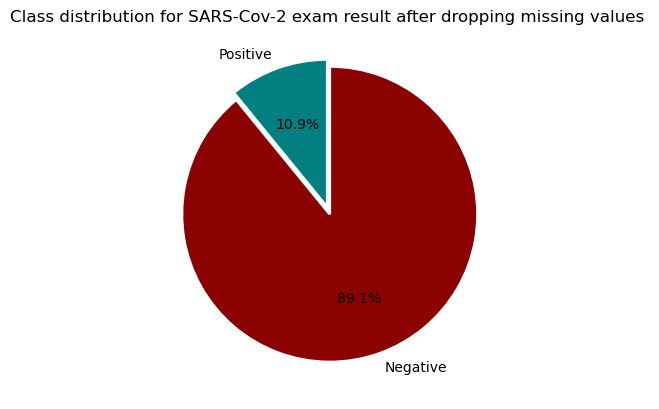

In [22]:
# Calculate percentages
total_results_valid = num_positives + num_negatives
positive_percents = (num_positives / total_results_valid) * 100
negative_percents = (num_negatives / total_results_valid) * 100

# Create pie chart
labels = ['Positive', 'Negative']
sizes = [positive_percents, negative_percents]
colors = ['teal','darkred']
explode = (0.05, 0)

fig, ax = plt.subplots()

# Create white circle to highlight break
circle = plt.Circle(xy=(0,0), radius=0.6, facecolor='white')
ax.add_artist(circle)

# Create pie chart
ax.pie(sizes, colors=colors, labels=labels, autopct='%1.1f%%', startangle=90, explode=explode, wedgeprops={'linewidth': 2, 'edgecolor': 'white'})

# Add title
plt.title('Class distribution for SARS-Cov-2 exam result after dropping missing values ')

# Show plot
plt.show()

In [23]:
valid_data.nunique()

Patient age quantile                                      20
SARS-Cov-2 exam result                                     2
Patient addmited to regular ward (1=yes, 0=no)             2
Patient addmited to semi-intensive unit (1=yes, 0=no)      2
Patient addmited to intensive care unit (1=yes, 0=no)      2
Hematocrit                                               152
Hemoglobin                                                77
Platelets                                                198
Mean platelet volume                                      44
Red blood Cells                                          180
Lymphocytes                                              236
Mean corpuscular hemoglobin concentration (MCHC)          55
Leukocytes                                               314
Basophils                                                 16
Mean corpuscular hemoglobin (MCH)                         81
Eosinophils                                               73
Mean corpuscular volume 

In [24]:
# Dropping columns irrelevant to this task 
valid_data = valid_data.drop(['Patient addmited to regular ward (1=yes, 0=no)', 'Patient addmited to semi-intensive unit (1=yes, 0=no)', 'Patient addmited to intensive care unit (1=yes, 0=no)'], axis=1)
valid_data.head()

,Patient age quantile,SARS-Cov-2 exam result,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,...,Rhinovirus/Enterovirus,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Metapneumovirus
1,17,negative,0.236515,-0.022340,-0.517413,0.010677,0.102004,0.318366,-0.950790,-0.094610,...,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected
8,1,negative,-1.571682,-0.774212,1.429667,-1.672222,-0.850035,-0.005738,3.331071,0.364550,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected
15,9,negative,-0.747693,-0.586244,-0.429480,-0.213711,-1.361315,-1.114514,0.542882,-0.884923,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected
18,11,negative,0.991838,0.792188,0.072992,-0.550290,0.542763,0.045436,-0.452899,-0.211488,...,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected
20,0,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected


In [25]:
null_perc = (valid_data.isnull().sum() / len(valid_data)) * 100
print(null_perc)

Patient age quantile                                 0.000000
SARS-Cov-2 exam result                               0.000000
Hematocrit                                          31.203008
Hemoglobin                                          31.203008
Platelets                                           31.203008
Mean platelet volume                                31.766917
Red blood Cells                                     31.203008
Lymphocytes                                         31.203008
Mean corpuscular hemoglobin concentration (MCHC)    31.203008
Leukocytes                                          31.203008
Basophils                                           31.203008
Mean corpuscular hemoglobin (MCH)                   31.203008
Eosinophils                                         31.203008
Mean corpuscular volume (MCV)                       31.203008
Monocytes                                           31.390977
Red blood cell distribution width (RDW)             31.203008
Respirat

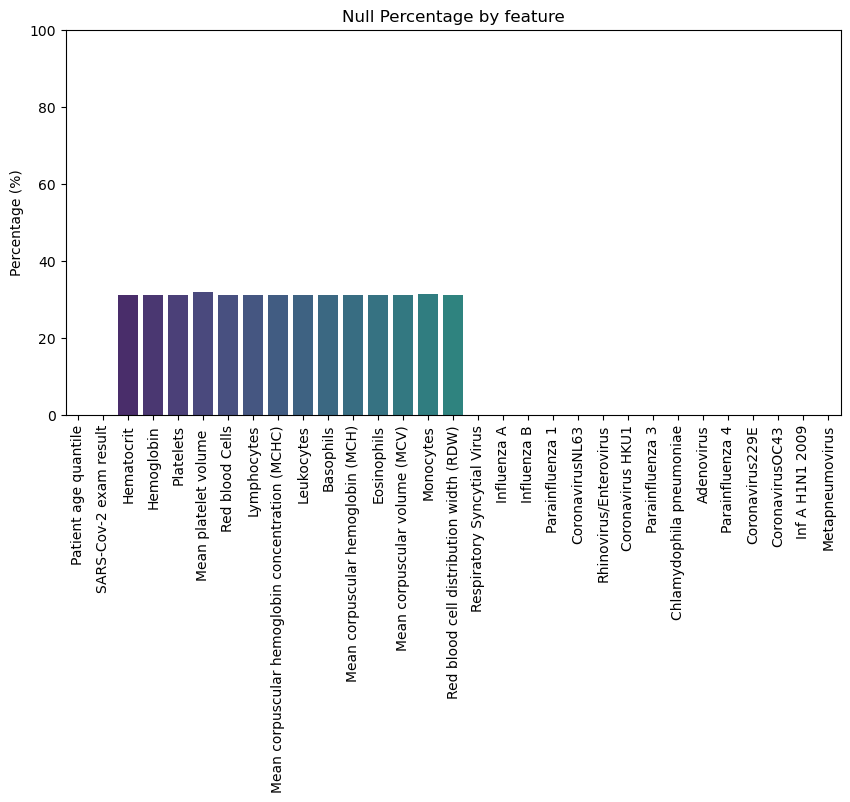

In [26]:
# Create a barplot of the missing data in each column
plt.figure(figsize=(10,5))
plt.title("Null Percentage by feature")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=90)
plt.ylim(0, 100)
sns.barplot(x=null_perc.index, y=null_perc.values, palette="viridis")
plt.show()

In [27]:
# Compute the percentage of NULL values in the entire dataset
total_null_percentage = (valid_data.isnull().sum().sum() / (valid_data.shape[0] * valid_data.shape[1])) * 100

# Print the result
print("Percentage of NULL values in the entire dataset: {:.2f}%".format(total_null_percentage))

Percentage of NULL values in the entire dataset: 14.12%


In [28]:
# Dropping Patient age quantile column since it has only 20 unique values between 0-19 age quantile, which means the data is more or less unique to the age category can't be taken into consideration as an overall metric for COVID detection
# Dropping numerical columns with 20 or less unique values
covid_dataset = valid_data.drop(['Patient age quantile', 'Basophils'], axis=1)

In [29]:
# create a dictionary to map values
map_dict = {
    'detected': 1,
    'not_detected': 0,
    'positive': 1,
    'negative': 0
}

In [30]:
# select columns to map
covid_dataset.replace(map_dict)

,SARS-Cov-2 exam result,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Mean corpuscular hemoglobin (MCH),...,Rhinovirus/Enterovirus,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Metapneumovirus
1,0,0.236515,-0.022340,-0.517413,0.010677,0.102004,0.318366,-0.950790,-0.094610,-0.292269,...,1,0,0,0,0,0,0,0,0,0
8,0,-1.571682,-0.774212,1.429667,-1.672222,-0.850035,-0.005738,3.331071,0.364550,0.178175,...,0,0,0,0,0,0,0,0,0,0
15,0,-0.747693,-0.586244,-0.429480,-0.213711,-1.361315,-1.114514,0.542882,-0.884923,1.746323,...,0,0,0,0,0,0,0,0,1,0
18,0,0.991838,0.792188,0.072992,-0.550290,0.542763,0.045436,-0.452899,-0.211488,0.334989,...,1,0,0,0,0,0,0,0,0,0
20,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5585,1,1.197836,1.356092,-1.911774,1.132609,0.384090,0.966573,0.841616,-0.834833,1.589509,...,0,0,0,0,0,0,0,0,0,0
5602,0,0.190738,0.165628,-0.102873,0.908221,0.384090,-1.583611,-0.054585,-0.328365,-0.449085,...,0,0,0,0,0,0,0,0,0,0
5614,0,-0.289922,-0.523588,0.663397,-0.774677,0.754327,-1.532437,-1.050367,1.569499,-2.174047,...,0,0,0,0,0,0,0,0,0,0
5615,0,0.717175,1.105468,-0.492289,-0.213711,0.613284,0.002791,1.538664,-0.550988,0.700891,...,0,0,0,0,0,0,0,0,0,0


In [31]:
# select columns to map
covid_dataset_new = covid_dataset.replace(map_dict)
covid_dataset_new.head()

,SARS-Cov-2 exam result,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Mean corpuscular hemoglobin (MCH),...,Rhinovirus/Enterovirus,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Metapneumovirus
1,0,0.236515,-0.022340,-0.517413,0.010677,0.102004,0.318366,-0.950790,-0.094610,-0.292269,...,1,0,0,0,0,0,0,0,0,0
8,0,-1.571682,-0.774212,1.429667,-1.672222,-0.850035,-0.005738,3.331071,0.364550,0.178175,...,0,0,0,0,0,0,0,0,0,0
15,0,-0.747693,-0.586244,-0.429480,-0.213711,-1.361315,-1.114514,0.542882,-0.884923,1.746323,...,0,0,0,0,0,0,0,0,1,0
18,0,0.991838,0.792188,0.072992,-0.550290,0.542763,0.045436,-0.452899,-0.211488,0.334989,...,1,0,0,0,0,0,0,0,0,0
20,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [32]:
covid_dataset_new.shape

(532, 29)

In [33]:
# Create a MICE imputer object with increased number of iterations
mice_imputer = IterativeImputer(max_iter=500, random_state=42)

# Fit the imputer to the data and transform it
imputed_data = mice_imputer.fit_transform(covid_dataset_new)

In [34]:
new_covid_data = pd.DataFrame(imputed_data, columns=covid_dataset_new.columns)
new_covid_data.head()

,SARS-Cov-2 exam result,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Mean corpuscular hemoglobin (MCH),...,Rhinovirus/Enterovirus,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Metapneumovirus
0,0.0,0.236515,-0.022340,-0.517413,0.010677,0.102004,0.318366,-0.950790,-0.094610,-0.292269,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,-1.571682,-0.774212,1.429667,-1.672222,-0.850035,-0.005738,3.331071,0.364550,0.178175,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,-0.747693,-0.586244,-0.429480,-0.213711,-1.361315,-1.114514,0.542882,-0.884923,1.746323,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.991838,0.792188,0.072992,-0.550290,0.542763,0.045436,-0.452899,-0.211488,0.334989,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,-0.434503,-0.495554,0.258379,-0.106079,-0.021915,1.027786,-0.391657,0.345945,-0.900235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
new_covid_data.shape

(532, 29)

In [36]:
# Compute the percentage of NULL values in the entire dataset
new_covid_data_null_percentage = (new_covid_data.isnull().sum().sum() / (new_covid_data.shape[0] * new_covid_data.shape[1])) * 100

# Print the result
print("Percentage of NULL values in the entire dataset: {:.2f}%".format(new_covid_data_null_percentage))

Percentage of NULL values in the entire dataset: 0.00%


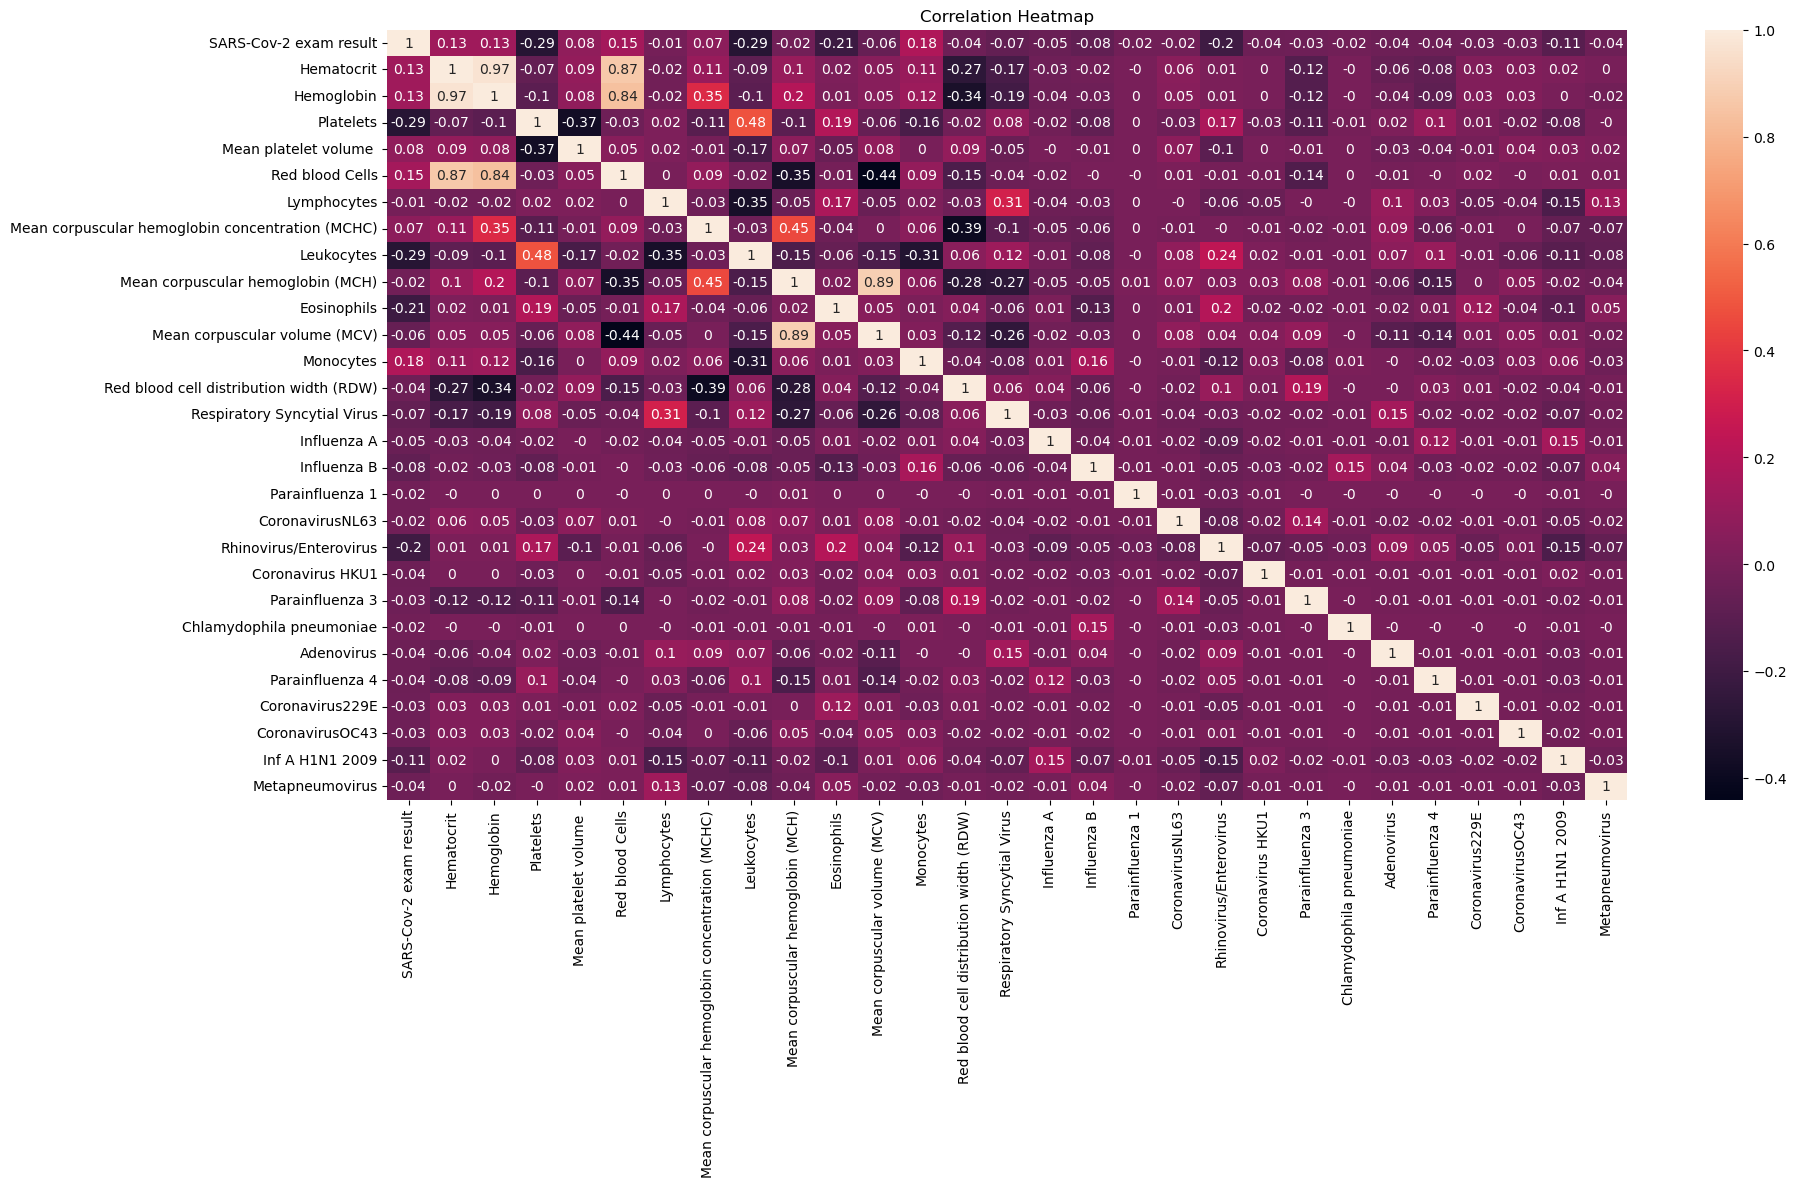

In [37]:
# Calculate the correlation matrix
corr_matrix = new_covid_data.corr().round(2)

# Create a heatmap
plt.figure(figsize=(20,10))
sns.heatmap(corr_matrix, annot = True);

# Set the title
plt.title('Correlation Heatmap')

# Show the plot
plt.show()

In [38]:
# Delete the features with highest correlation positive/negative in order to reduce redundancy and simplify the model.
# Keeping high correlation threshold at >0.95 for positive correlation and <-0.40 for negative correlation

covid_dataset_final = new_covid_data.drop(['Hematocrit', 'Mean corpuscular volume (MCV)'], axis=1)
covid_dataset_final.head()

,SARS-Cov-2 exam result,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Mean corpuscular hemoglobin (MCH),Eosinophils,...,Rhinovirus/Enterovirus,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Metapneumovirus
0,0.0,-0.022340,-0.517413,0.010677,0.102004,0.318366,-0.950790,-0.094610,-0.292269,1.482158,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,-0.774212,1.429667,-1.672222,-0.850035,-0.005738,3.331071,0.364550,0.178175,1.018625,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,-0.586244,-0.429480,-0.213711,-1.361315,-1.114514,0.542882,-0.884923,1.746323,-0.666950,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.792188,0.072992,-0.550290,0.542763,0.045436,-0.452899,-0.211488,0.334989,-0.709090,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,-0.495554,0.258379,-0.106079,-0.021915,1.027786,-0.391657,0.345945,-0.900235,-0.080319,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
# Assuming X is the feature matrix and y is the target variable in your dataframe
X = covid_dataset_final.drop(['SARS-Cov-2 exam result'], axis=1)
y = covid_dataset_final['SARS-Cov-2 exam result']

In [40]:
# Initialize SMOTE
sm = SMOTE(random_state=42)

# Resample the data using SMOTE
X_resampled, y_resampled = sm.fit_resample(X, y)

# Print the shape of the resampled data
print("Original dataset shape:", X.shape, y.shape)
print("Resampled dataset shape:", X_resampled.shape, y_resampled.shape)

Original dataset shape: (532, 26) (532,)
Resampled dataset shape: (948, 26) (948,)


In [41]:
# total value count for 0 and 1 post over-sampling
covid_dataset_final = pd.DataFrame(y_resampled, columns=['SARS-Cov-2 exam result'])
print(covid_dataset_final['SARS-Cov-2 exam result'].value_counts())

0.0    474
1.0    474
Name: SARS-Cov-2 exam result, dtype: int64


In [42]:
# Initialize StandardScaler
scaler = StandardScaler()

# Normalize the data
X_resampled_norm = scaler.fit_transform(X_resampled)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled_norm, y_resampled, test_size=0.2, random_state=42)

In [43]:
# Train a random forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf.predict(X_test)

# Generate classification report
target_names = ['0', '1']
report_rf = classification_report(y_test, y_pred, target_names=target_names)

# Print classification report
print(report_rf)

              precision    recall  f1-score   support

           0       0.97      0.95      0.96        97
           1       0.95      0.97      0.96        93

    accuracy                           0.96       190
   macro avg       0.96      0.96      0.96       190
weighted avg       0.96      0.96      0.96       190



In [44]:
from sklearn.metrics import accuracy_score

# calculate accuracy score
accuracy_rf = accuracy_score(y_test, y_pred)

# print the accuracy score
print("Accuracy:", accuracy_rf)

Accuracy: 0.9578947368421052


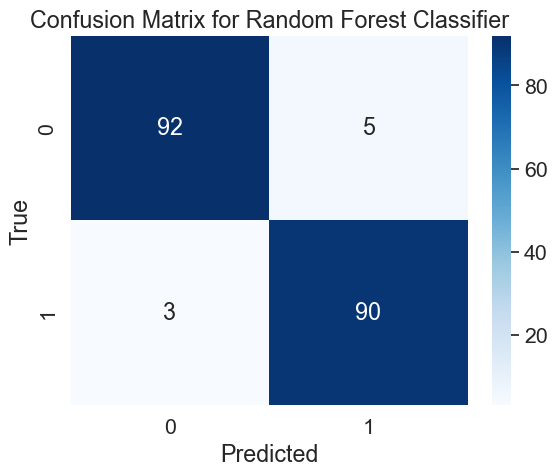

In [45]:
# Plot the Confusion Matrix for Random Forest Classifier
confusion_rf = confusion_matrix(y_test, y_pred)
sns.set(font_scale=1.4)
sns.heatmap(confusion_rf, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()

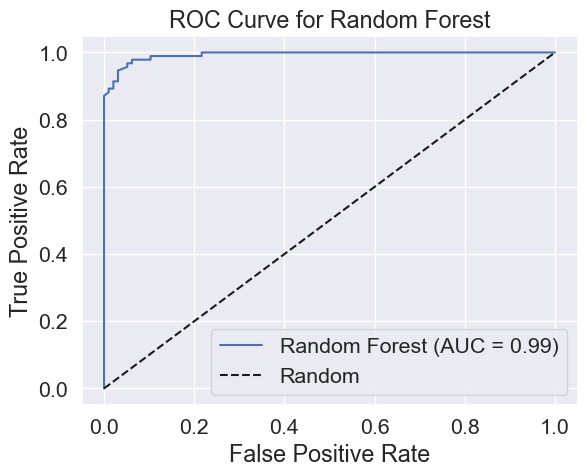

In [46]:
# Assuming X and y are defined as in the Random Forest example above
# and the classifier is trained and stored in the `rf` variable

# Predict the probabilities for the test set
y_proba = rf.predict_proba(X_test)[:, 1]

# Compute the false positive rate and true positive rate at different thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Compute the area under the ROC curve
roc_auc_rf = roc_auc_score(y_test, y_proba)

# Plot the ROC curve
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {roc_auc_rf:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest')
plt.legend()
plt.show()

In [47]:
# Train a logistic regression classifier
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lr.predict(X_test)

# Generate classification report
target_names = ['0', '1']
report_lr = classification_report(y_test, y_pred, target_names=target_names)

# Print classification report
print(report_lr)

              precision    recall  f1-score   support

           0       0.94      0.88      0.91        97
           1       0.88      0.95      0.91        93

    accuracy                           0.91       190
   macro avg       0.91      0.91      0.91       190
weighted avg       0.91      0.91      0.91       190



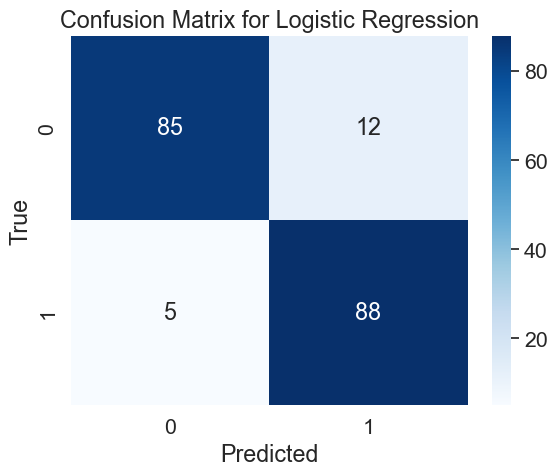

In [48]:
# Generate confusion matrix
confusion_lr = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
sns.set(font_scale=1.4)
sns.heatmap(confusion_lr, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

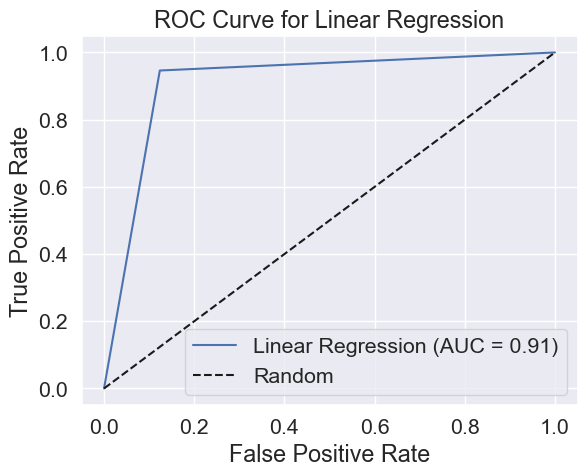

In [49]:
# Assuming X and y are defined as in the Linear Regression example above
# and the classifier is trained and stored in the `lr` variable

# Predict the probabilities for the test set
y_score = lr.predict(X_test)

# Compute the false positive rate and true positive rate at different thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# Compute the area under the ROC curve
roc_auc_lr = roc_auc_score(y_test, y_score)

# Plot the ROC curve
plt.plot(fpr, tpr, label=f"Linear Regression (AUC = {roc_auc_lr:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Linear Regression')
plt.legend()
plt.show()

In [50]:
from sklearn.tree import DecisionTreeClassifier

# Train a Decision Tree classifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Make predictions on the test set
y_pred = dt.predict(X_test)

# Generate classification report
target_names = ['0', '1']
report_dt = classification_report(y_test, y_pred, target_names=target_names)

# Print classification report
print(report_dt)

              precision    recall  f1-score   support

           0       0.94      0.88      0.91        97
           1       0.88      0.95      0.91        93

    accuracy                           0.91       190
   macro avg       0.91      0.91      0.91       190
weighted avg       0.91      0.91      0.91       190



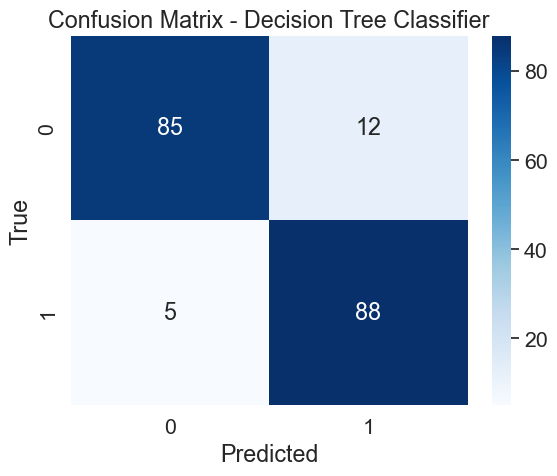

In [51]:
# Plot the Confusion Matrix for Decision Tree Classifier
confusion_dt = confusion_matrix(y_test, y_pred)
sns.set(font_scale=1.4)
sns.heatmap(confusion_dt, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Decision Tree Classifier')
plt.show()

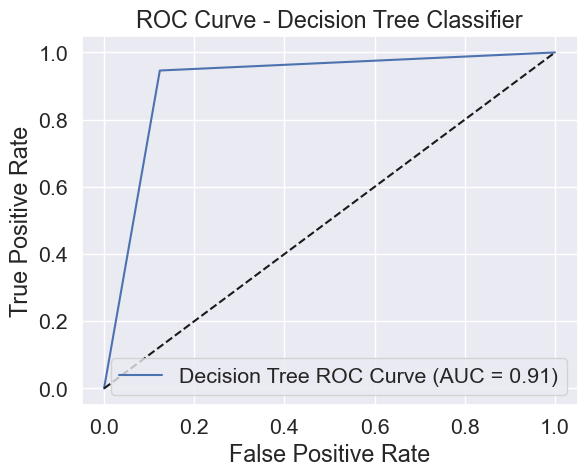

In [52]:
# Generate ROC curve and AUC score for Decision Tree Classifier
y_pred_proba = dt.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score_dt = roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr, tpr, label=f'Decision Tree ROC Curve (AUC = {auc_score_dt:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree Classifier')
plt.legend()
plt.show()

In [53]:
# Train an SVM classifier
svm = SVC(kernel='linear', C=1, random_state=42)
svm.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm.predict(X_test)

# Generate classification report
target_names = ['0', '1']
report_svm = classification_report(y_test, y_pred, target_names=target_names)

# Print classification report
print(report_svm)

              precision    recall  f1-score   support

           0       0.91      0.87      0.89        97
           1       0.87      0.91      0.89        93

    accuracy                           0.89       190
   macro avg       0.89      0.89      0.89       190
weighted avg       0.89      0.89      0.89       190



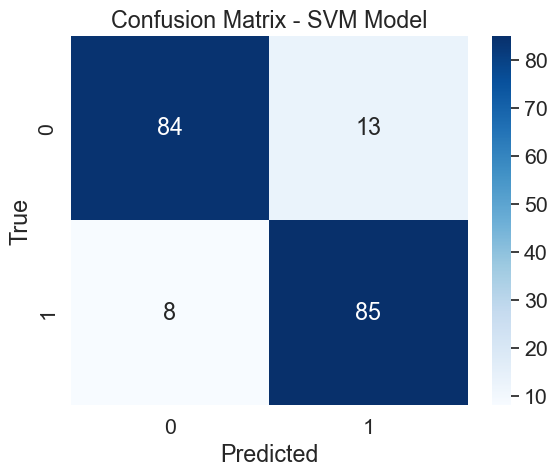

In [54]:
# Plot the Confusion Matrix
confusion_svm = confusion_matrix(y_test, y_pred)
sns.set(font_scale=1.4)
sns.heatmap(confusion_svm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - SVM Model')
plt.show()

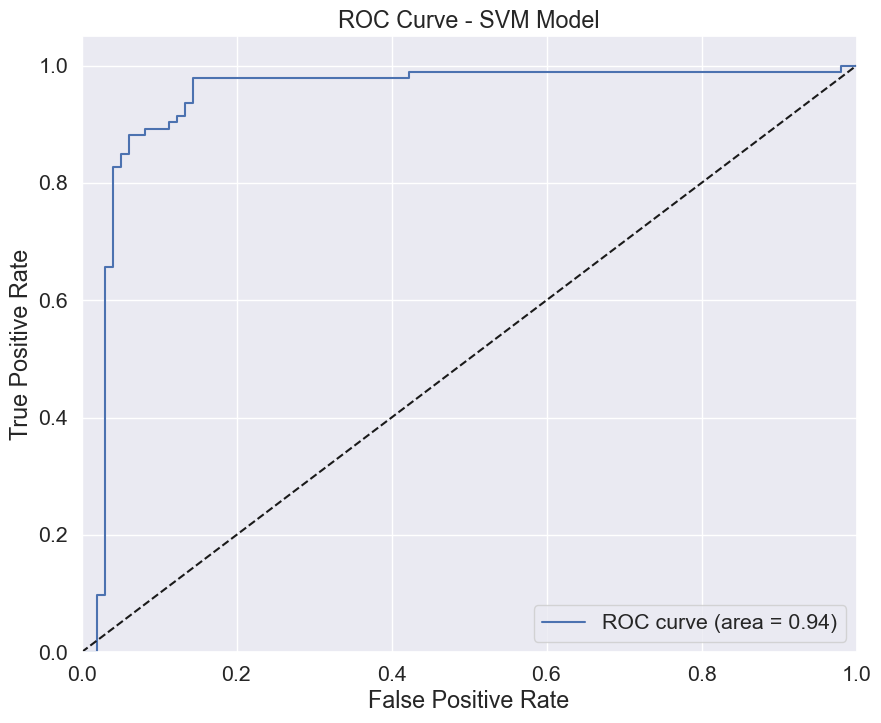

In [55]:
# Generate ROC Curve and AUC score
y_score = svm.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc_svm = roc_auc_score(y_test, y_score)

# Plot ROC Curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_svm)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM Model')
plt.legend(loc="lower right")
plt.show()

In [56]:
# Train a KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Make predictions on the test set
y_pred = knn.predict(X_test)

# Generate classification report
target_names = ['0', '1']
report_knn = classification_report(y_test, y_pred, target_names=target_names)

# Print classification report
print(report_knn)

              precision    recall  f1-score   support

           0       0.99      0.87      0.92        97
           1       0.88      0.99      0.93        93

    accuracy                           0.93       190
   macro avg       0.93      0.93      0.93       190
weighted avg       0.93      0.93      0.93       190



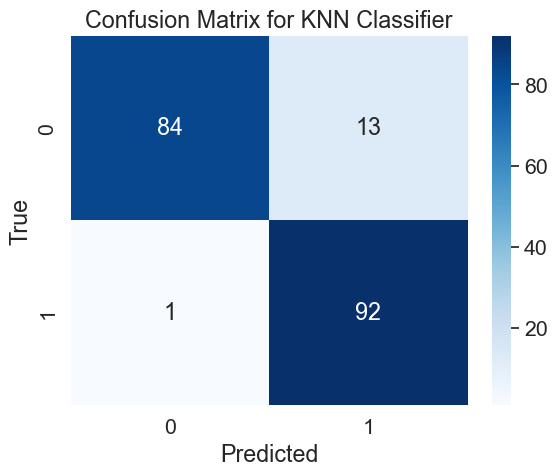

In [57]:
# Generate confusion matrix
confusion_knn = confusion_matrix(y_test, y_pred)
sns.set(font_scale=1.4)
sns.heatmap(confusion_knn, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for KNN Classifier')
plt.show()

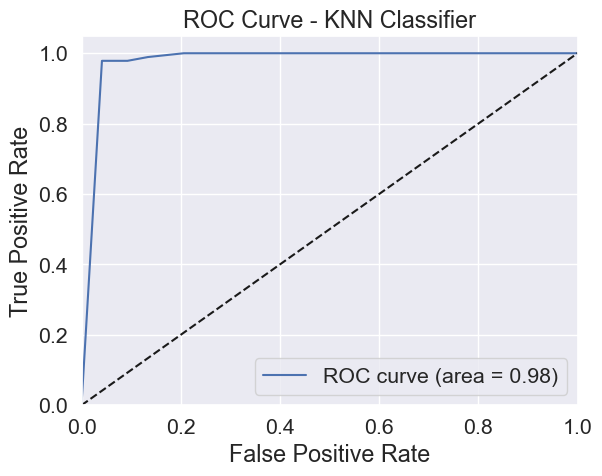

In [58]:
# Get predicted probabilities for positive class
y_pred_proba = knn.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc_knn = roc_auc_score(y_test, y_pred_proba)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_knn)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - KNN Classifier')
plt.legend(loc="lower right")
plt.show()

In [59]:
covid_dataset_final_test = pd.DataFrame(X_resampled)

In [60]:
covid_dataset_final_test.shape

(948, 26)

In [61]:
# Define the features and target variables
target = 'SARS-Cov-2 exam result'
features = covid_dataset_final_test.columns[covid_dataset_final_test.columns != target]

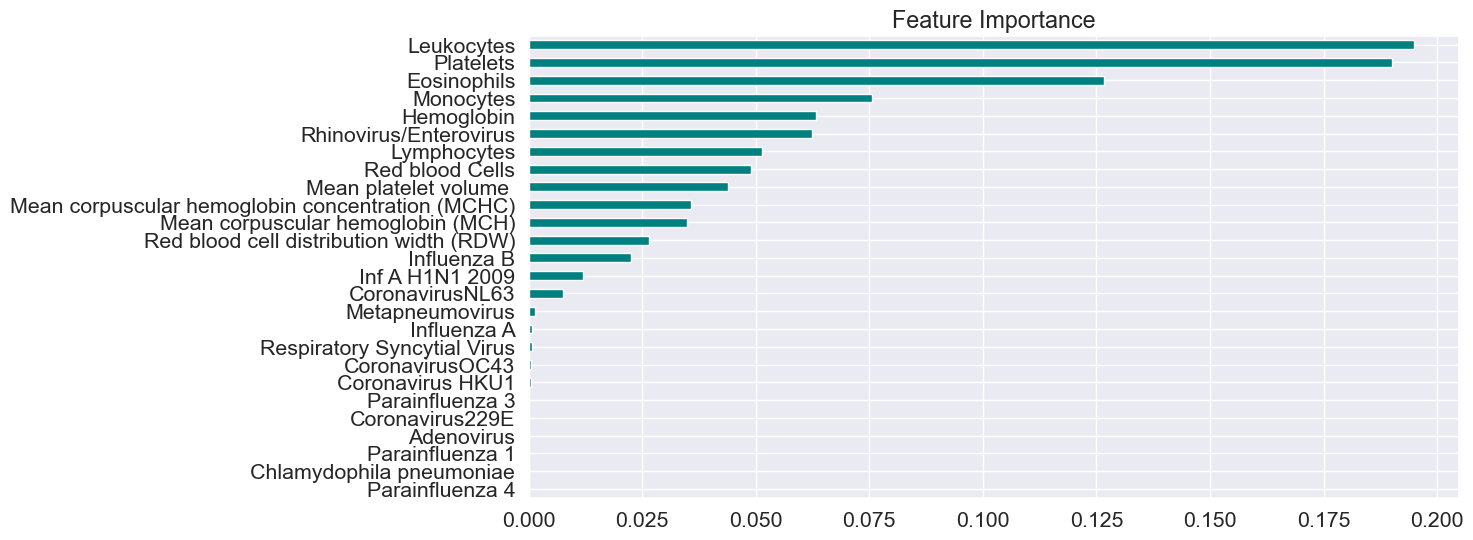

                                                  importance
Leukocytes                                            0.1949
Platelets                                             0.1900
Eosinophils                                           0.1267
Monocytes                                             0.0755
Hemoglobin                                            0.0632
Rhinovirus/Enterovirus                                0.0624
Lymphocytes                                           0.0513
Red blood Cells                                       0.0490
Mean platelet volume                                  0.0439
Mean corpuscular hemoglobin concentration (MCHC)      0.0358
Mean corpuscular hemoglobin (MCH)                     0.0348
Red blood cell distribution width (RDW)               0.0265
Influenza B                                           0.0225
Inf A H1N1 2009                                       0.0119
CoronavirusNL63                                       0.0076
Metapneumovirus         

In [62]:
# Split the data into training and testing sets
X = covid_dataset_final_test[features]
y = covid_dataset_final[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the random forest model
rf = RandomForestClassifier()

# Fit the model
rf.fit(X_train, y_train)

# Compute feature importances
feature_importances = pd.DataFrame(rf.feature_importances_,
                                    index = features,
                                    columns=['importance']).sort_values('importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12,6))
feature_importances.sort_values(by='importance', ascending=True, inplace=True)
feature_importances.importance.plot(kind='barh', color='teal')
plt.title('Feature Importance')
plt.show()

# Print feature importances
print(feature_importances.sort_values(by='importance', ascending=False).round(4))